In [1]:
# generated by Chat GPT
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
# generated by Chat GPT
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


In [11]:
# generated by Chat GPT
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Replace 'path_to_your_images' with your dataset folder path
dataset = CustomImageDataset(root_dir='./archive/pokemon_jpg/pokemon_jpg/', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)


In [12]:
# generated by Chat GPT
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.mask_type = mask_type
        # Create mask same shape as weight
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kh, kw = self.weight.size()
        self.mask.fill_(1)
        yc, xc = kh // 2, kw // 2

        if mask_type == 'A':
            # For the first layer, mask the center pixel and pixels to the right/below
            self.mask[:, :, yc, xc:] = 0
            self.mask[:, :, yc+1:] = 0
        else:  # mask_type == 'B'
            # For subsequent layers, allow the center pixel but mask future pixels
            self.mask[:, :, yc, xc+1:] = 0
            self.mask[:, :, yc+1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)


In [13]:
# generated by Chat GPT
class PixelCNN(nn.Module):
    def __init__(self, input_channels=3, n_filters=64, kernel_size=7, n_layers=7, n_classes=256):
        super(PixelCNN, self).__init__()
        self.input_channels = input_channels
        self.n_classes = n_classes

        self.net = nn.ModuleList()
        # First layer with Mask-A convolution
        self.net.append(MaskedConv2d('A', input_channels, n_filters, kernel_size, padding=kernel_size//2))
        self.net.append(nn.ReLU())

        # Subsequent layers with Mask-B convolutions
        for _ in range(n_layers):
            self.net.append(MaskedConv2d('B', n_filters, n_filters, kernel_size, padding=kernel_size//2))
            self.net.append(nn.ReLU())

        # Final 1x1 convolution to output logits for each class per channel
        self.out_conv = nn.Conv2d(n_filters, input_channels * n_classes, 1)

    def forward(self, x):
        for layer in self.net:
            x = layer(x)
        x = self.out_conv(x)
        # Reshape to [B, input_channels, n_classes, H, W]
        B, _, H, W = x.size()
        x = x.view(B, self.input_channels, self.n_classes, H, W)
        return x


In [19]:
# generated by Chat GPT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PixelCNN(input_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 100  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images in dataloader:
        images = images.to(device)
        # Quantize the pixel values (0-255) for each channel as target labels
        targets = (images * 255).long()

        optimizer.zero_grad()
        outputs = model(images)  # [B, 3, 256, H, W]
        # Rearrange outputs to [B*3*H*W, 256] and targets to [B*3*H*W]
        outputs = outputs.permute(0, 1, 3, 4, 2).contiguous().view(-1, model.n_classes)
        targets = targets.view(-1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")


Epoch [1/100], Loss: 4.4498
Epoch [2/100], Loss: 3.4672
Epoch [3/100], Loss: 3.3665
Epoch [4/100], Loss: 3.2625
Epoch [5/100], Loss: 3.1411
Epoch [6/100], Loss: 3.0935
Epoch [7/100], Loss: 3.0144
Epoch [8/100], Loss: 2.9181
Epoch [9/100], Loss: 2.8546
Epoch [10/100], Loss: 2.8175
Epoch [11/100], Loss: 2.8227
Epoch [12/100], Loss: 2.8266
Epoch [13/100], Loss: 2.7651
Epoch [14/100], Loss: 2.7829
Epoch [15/100], Loss: 2.7291
Epoch [16/100], Loss: 2.7792
Epoch [17/100], Loss: 2.7418
Epoch [18/100], Loss: 2.6898
Epoch [19/100], Loss: 2.6698
Epoch [20/100], Loss: 2.7181
Epoch [21/100], Loss: 2.8240
Epoch [22/100], Loss: 2.6825
Epoch [23/100], Loss: 2.6629
Epoch [24/100], Loss: 2.6468
Epoch [25/100], Loss: 2.6263
Epoch [26/100], Loss: 2.6812
Epoch [27/100], Loss: 2.6664
Epoch [28/100], Loss: 2.6915
Epoch [29/100], Loss: 2.6859
Epoch [30/100], Loss: 2.6816
Epoch [31/100], Loss: 2.6122
Epoch [32/100], Loss: 2.6331
Epoch [33/100], Loss: 2.6451
Epoch [34/100], Loss: 2.5849
Epoch [35/100], Loss: 2

In [20]:
# generated by Chat GPT
model_path = 'pixelcnn.pth'
torch.save(model.state_dict(), model_path)
print("Model saved.")


Model saved.


In [21]:
# generated by Chat GPT
loaded_model = PixelCNN(input_channels=3).to(device)
loaded_model.load_state_dict(torch.load(model_path, map_location=device))
loaded_model.eval()
print("Model loaded.")


Model loaded.


C:\Users\Andrew\AppData\Local\Temp\ipykernel_24568\2359939336.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path, map_loc

In [27]:
# generated by Chat GPT
def sample(model, image_size=32, n_channels=3):
    model.eval()
    # Initialize an empty image tensor
    sample_img = torch.zeros(1, n_channels, image_size, image_size).to(device)

    with torch.no_grad():
        for i in range(image_size):
            for j in range(image_size):
                outputs = model(sample_img)  # [1, 3, 256, H, W]
                # For each channel, sample the pixel value
                for c in range(n_channels):
                    logits = outputs[0, c, :, i, j]  # [256]
                    probs = torch.softmax(logits, dim=0)
                    sampled_val = torch.multinomial(probs, 1)
                    # Set the pixel value (normalize back to [0,1])
                    sample_img[0, c, i, j] = sampled_val.float() / 255.0
    return sample_img

# Generate a sample image
generated_image = sample(loaded_model, image_size=32, n_channels=3)


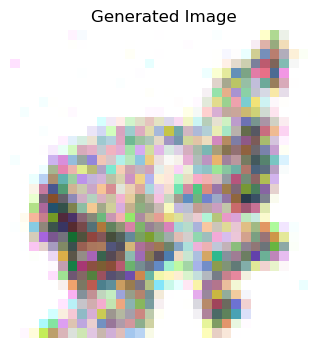

In [28]:
# generated by Chat GPT
# Convert tensor to numpy format and display
img_np = generated_image.cpu().squeeze().permute(1, 2, 0).numpy()
plt.figure(figsize=(4,4))
plt.imshow(img_np)
plt.axis('off')
plt.title("Generated Image")
plt.show()


This model performs similarly to the vae for Pokemon generation. I chose this because I was not able to implement a diffusion transformer. It was very easy to implement.